# Policy Uncertainty as a Predictor of CME Price Movement

This study investigates whether shifts in implied probability from prediction markets can
predict next-day returns in CME Group futures.

The core hypothesis is grounded in CME's business model: as a transaction-fee-driven exchange, CME's revenue is a direct function of hedging volume, and hedging volume is a direct function of policy uncertainty. If prediction market entropy captures genuine uncertainty shocks, it should lead observable price appreciation in CME.

The prediction market in question is Polymarket's contracts on the outcome of the March 2026 Federal Reserve rate decision.

In [106]:
from collections import defaultdict
import csv
from datetime import datetime, timezone
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import requests
import statsmodels.api as sm

## Input/Output

In [107]:
PM_DIR = Path("data/polymarket")
CME_OHLC_PATH = Path("data/cme/daily_ohlc.csv")
PROXY_PM = "will-the-fed-increase-interest-rates-by-25-bps-after-the-march-2026-meeting_NO.csv"

Download historic price data from Polymarket. [See Documentation](https://docs.polymarket.com/developers/CLOB/timeseries)

| From               | To                  |
| ------------------ | ------------------- |
| November 1st, 2025 | February 16th, 2026 |

In [108]:
FIELD_NAMES = ["p", "t"]

START_DATES = [
    int(datetime(2025, 11, 1, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 11, 16, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 1, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 16, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1,  1, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1, 16, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 2,  1, tzinfo=timezone.utc).timestamp()),
]

END_DATES = [
    int(datetime(2025, 11, 15, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 11, 30, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 15, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 31, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1, 15, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1, 31, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 2, 16, tzinfo=timezone.utc).timestamp()),
]

result = defaultdict(list)

with open('data/fed-decision-in-march-885_SUMMARY.json') as f:
    polymarket_summary = json.load(f)
    markets = polymarket_summary["markets"]
    
    for market in markets:
        market_id = market["id"]
        market_name = market["question"]
        slug = market["slug"]
        outcomes = json.loads(market["outcomes"])
        clobs = [int(clob_str) for clob_str in json.loads(market["clobTokenIds"])]
        
        
        for outcome, clob in zip(outcomes, clobs):
            security = f"{slug}_{outcome.upper()}"

            maybe_out = os.path.join(PM_DIR, f"{security}.csv")
            if os.path.exists(maybe_out):
                print(f"skipping {maybe_out}")
                continue
            
            for start, end in zip(START_DATES, END_DATES):
                request_curl = f'https://clob.polymarket.com/prices-history?market={clob}&startTs={start}&endTs={end}'

                res = requests.get(request_curl)
                if res.status_code != 200:
                    print(request_curl)
                    reason = res.json()
                    raise Exception(f"{res.status_code}: could not fetch for {market_name}: {reason}")
            
                result[security] += (res.json()["history"])
            
for security, data in result.items():
    # de-dup by timestamp; keep last occurrence
    by_t = {}
    for row in data:
        t = int(row["t"])
        by_t[t] = {"p": float(row["p"]), "t": t}

    rows = [by_t[t] for t in sorted(by_t.keys())]

    out = os.path.join(PM_DIR, f"{security}.csv")
    with open(out, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=FIELD_NAMES)
        writer.writeheader()
        writer.writerows(rows)

        print(out)

data/polymarket/will-the-fed-decrease-interest-rates-by-50-bps-after-the-march-2026-meeting_YES.csv
data/polymarket/will-the-fed-decrease-interest-rates-by-50-bps-after-the-march-2026-meeting_NO.csv
data/polymarket/will-the-fed-decrease-interest-rates-by-25-bps-after-the-march-2026-meeting_YES.csv
data/polymarket/will-the-fed-decrease-interest-rates-by-25-bps-after-the-march-2026-meeting_NO.csv
data/polymarket/will-there-be-no-change-in-fed-interest-rates-after-the-march-2026-meeting_YES.csv
data/polymarket/will-there-be-no-change-in-fed-interest-rates-after-the-march-2026-meeting_NO.csv
data/polymarket/will-the-fed-increase-interest-rates-by-25-bps-after-the-march-2026-meeting_YES.csv
data/polymarket/will-the-fed-increase-interest-rates-by-25-bps-after-the-march-2026-meeting_NO.csv


In [109]:
ohlc_df = pd.read_csv(CME_OHLC_PATH, sep="\t")
ohlc_df["Exchange Date"] = pd.to_datetime(ohlc_df["Exchange Date"])

ohlc_df = ohlc_df.set_index("Exchange Date").sort_index()

ohlc_df = ohlc_df[["Close"]].copy()
ohlc_df["Close"] = pd.to_numeric(ohlc_df["Close"], errors="coerce")

# Correct log returns
ohlc_df["ret"] = np.log(ohlc_df["Close"]).diff()

ohlc_df.tail()

/var/folders/5t/tbhys9bs5z50rr8f8h42bmyw0000gn/T/ipykernel_5113/144815481.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ohlc_df["Exchange Date"] = pd.to_datetime(ohlc_df["Exchange Date"])


,Close,ret
Exchange Date,,
2026-02-09,307.24,0.016309
2026-02-10,306.76,-0.001564
2026-02-11,302.48,-0.014051
2026-02-12,301.64,-0.002781
2026-02-13,303.07,0.004730


In [110]:
pm_df = pd.read_csv(PM_DIR / PROXY_PM)

pm_df["t"] = pd.to_datetime(pm_df["t"], unit='s')
pm_df = pm_df.set_index("t").sort_index()

pm_df = pm_df.rename(columns={"p": "pm_prob"})[["pm_prob"]].copy()
pm_df = pm_df[["pm_prob"]].copy()
pm_df["pm_prob"] = pd.to_numeric(pm_df["pm_prob"], errors="coerce")
pm_df.head()

,pm_prob
t,
2025-11-01 00:00:06,0.96
2025-11-01 00:01:05,0.96
2025-11-01 00:02:04,0.96
2025-11-01 00:03:04,0.96
2025-11-01 00:04:04,0.96


In [111]:
pm_bday = pm_df.resample("B").last()

df = ohlc_df.merge(pm_bday, left_index=True, right_index=True, how="left").dropna()

p = df["pm_prob"].clip(1e-6, 1-1e-6)
df["uncert"] = -(p*np.log(p) + (1-p)*np.log(1-p))   # entropy
df["d_uncert"] = df["uncert"].diff()

df.tail()

,Close,ret,pm_prob,uncert,d_uncert
Exchange Date,,,,,
2026-02-09,307.24,0.016309,0.9905,0.053691,0.000000
2026-02-10,306.76,-0.001564,0.9905,0.053691,0.000000
2026-02-11,302.48,-0.014051,0.9935,0.039213,-0.014479
2026-02-12,301.64,-0.002781,0.9925,0.044168,0.004956
2026-02-13,303.07,0.004730,0.9945,0.034101,-0.010067


In [112]:
threshold = df["d_uncert"].abs().quantile(0.85)
df["big_uncert"] = (df["d_uncert"].abs() > threshold).astype(int)

y = df["ret"].shift(-1)
X = sm.add_constant(df[["big_uncert"]])
model = sm.OLS(y, X, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags":5})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.295
Date:                Tue, 17 Feb 2026   Prob (F-statistic):             0.0421
Time:                        13:39:14   Log-Likelihood:                 209.23
No. Observations:                  68   AIC:                            -414.5
Df Residuals:                      66   BIC:                            -410.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.799      0.4

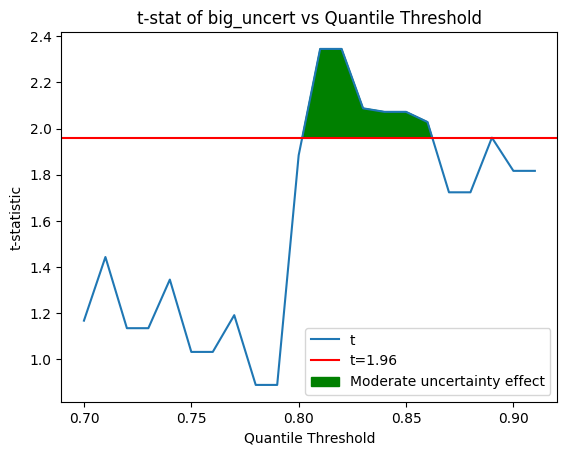

In [113]:
results = []
for q in np.arange(0.7, 0.91, 0.01):
    threshold = df["d_uncert"].abs().quantile(q)
    df["big_uncert"] = (df["d_uncert"].abs() > threshold).astype(int)

    y = df["ret"].shift(-1)
    X = sm.add_constant(df[["big_uncert"]])
    model = sm.OLS(y, X, missing="drop").fit(
        cov_type="HAC", cov_kwds={"maxlags":5}
    )

    results.append((q, model.tvalues["big_uncert"]))

results_df = pd.DataFrame(results, columns=["quantile", "tstat"])

plt.figure()
plt.plot(results_df["quantile"], results_df["tstat"], label='t')
plt.axhline(1.96, color='r', label='t=1.96')
plt.fill_between(
    results_df["quantile"],
    1.96,
    results_df["tstat"],
    where=list(results_df["tstat"] > 1.96),
    interpolate=True,
    color='g',
    label='Moderate uncertainty effect'
)
plt.xlabel("Quantile Threshold")
plt.ylabel("t-statistic")
plt.title("t-stat of big_uncert vs Quantile Threshold")

plt.legend()

plt.show()


## Takeaway

A moderate, threshold-sensitive but directionally stable effect. The effect is strongest around upper-quintile to upper-decile shocks.

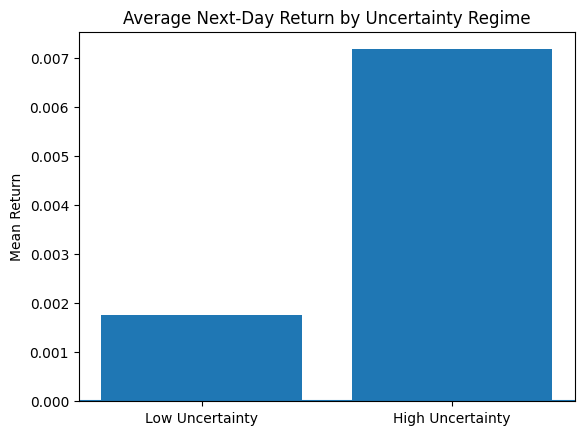

In [114]:
df_plot = df.copy()
df_plot["ret_fwd"] = df_plot["ret"].shift(-1)

group_means = df_plot.groupby("big_uncert")["ret_fwd"].mean()

plt.figure()
plt.bar(["Low Uncertainty", "High Uncertainty"], group_means)
plt.axhline(0)
plt.title("Average Next-Day Return by Uncertainty Regime")
plt.ylabel("Mean Return")
plt.show()

# Strategy
When uncertainty shocks are large, expected next-day returns are higher. So increase exposure in that regime.

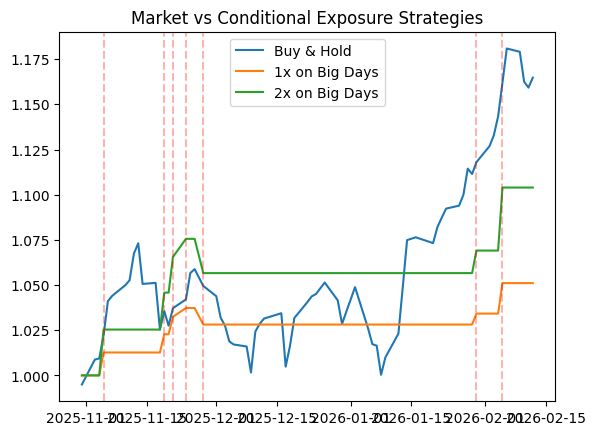

In [115]:
df_plot = df.copy()
df_plot["ret_fwd"] = df_plot["ret"].shift(-1)

# --- Baseline: 1x only on big days ---
df_plot["strategy_ret_1x"] = (
    df_plot["big_uncert"] * df_plot["ret_fwd"]
)

# --- Double-up: 2x only on big days ---
df_plot["strategy_ret_2x"] = (
    2.0 * df_plot["big_uncert"] * df_plot["ret_fwd"]
)

df_plot = df_plot.dropna(subset=["ret_fwd"])

# cumulative returns
df_plot["cum_market"] = (1 + df_plot["ret_fwd"]).cumprod()
df_plot["cum_strategy_1x"] = (1 + df_plot["strategy_ret_1x"]).cumprod()
df_plot["cum_strategy_2x"] = (1 + df_plot["strategy_ret_2x"]).cumprod()

plt.figure()
plt.plot(df_plot.index, df_plot["cum_market"], label="Buy & Hold")
plt.plot(df_plot.index, df_plot["cum_strategy_1x"], label="1x on Big Days")
plt.plot(df_plot.index, df_plot["cum_strategy_2x"], label="2x on Big Days")

for date in df_plot.index[df_plot["big_uncert"] == 1]:
    plt.axvline(x=date, linestyle="--", alpha=0.3, color='r')


plt.legend()
plt.title("Market vs Conditional Exposure Strategies")
plt.show()


# Sharpe Ratios per Strategy

In [116]:
def sharpe(r):
    return r.mean() / r.std()

def max_drawdown(cum):
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

metrics = pd.DataFrame({
    "Market": [
        df_plot["ret_fwd"].mean(),
        df_plot["ret_fwd"].std(),
        sharpe(df_plot["ret_fwd"]),
        max_drawdown(df_plot["cum_market"])
    ],
    "1x": [
        df_plot["strategy_ret_1x"].mean(),
        df_plot["strategy_ret_1x"].std(),
        sharpe(df_plot["strategy_ret_1x"]),
        max_drawdown(df_plot["cum_strategy_1x"])
    ],
    "2x": [
        df_plot["strategy_ret_2x"].mean(),
        df_plot["strategy_ret_2x"].std(),
        sharpe(df_plot["strategy_ret_2x"]),
        max_drawdown(df_plot["cum_strategy_2x"])
    ],
}, index=["Mean Return", "Volatility", "Sharpe", "Max Drawdown"])

metrics

,Market,1x,2x
Mean Return,0.002310,0.000738,0.001476
Volatility,0.011441,0.003262,0.006524
Sharpe,0.201894,0.226265,0.226265
Max Drawdown,-0.067794,-0.008814,-0.017629


# Interpretation

The findings fit neatly into a well-established thesis about how CME Group's business model is structurally wired to benefit from policy uncertainty.

## Monetization
CME earns revenue almost entirely through transaction fees, making their top line a direct function of volume, and volume a direct function of volatility. "Investors have more differential interpretations of firms’ earnings news when they are uncertain about market conditions" ([Choi](https://www.sciencedirect.com/science/article/pii/S1544612318304021)). Therefore, there is greater variability between CME's stock price and their potential revenue from an uncertain macro regime.

## Polymarket
The uncertainty signal identified in the Polymarket data may a real-time proxy for this dynamic. The days flagged as high-entropy (85th quantile) correspond to moments when the market is genuinely repricing the Fed's reaction function.

The statistically significant positive next-day return following these uncertainty spikes (coef = 0.0058, p = 0.038) is consistent with the market recognizing, with a slight lag, that volatility regimes are sticky.

## Implications
The conditional strategies match or slightly exceed the market's Sharpe ratio while reducing max drawdown by roughly 75–87%. This is consistent with the core thesis: uncertainty shocks are identifiable regime signals that carry information about near-term CME earnings power.

## Limitations

1. With only 3 months of daily data, there is a real risk of overfitting to noise.
2. Comparing Sharpe ratios between a fully-invested strategy and a sparse one isn't apples-to-apples.
3. The positive next-day return on high-entropy days could reflect the broader market uncertainty regime driving both variables.

## Next Steps
This study is more of a preliminary screen than a publishable result. The most important next step would be expanding the dataset and controlling for VIX, market-wide returns, or earnings periods.